# Flight Ticket Price Prediction:

In [1]:
# Import the must required librarires....

import pandas as pd
import numpy as np

# import libraries for visuallization of the data....
import seaborn as sns
import matplotlib.pyplot as plt

# import library for statistical analysis....
import scipy.stats as stats
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

# for splitting the data...
from sklearn.model_selection import train_test_split

# import librarires for modelling purpose...
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,AdaBoostClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# import libraries for model eavaluation....
from sklearn.metrics import roc_auc_score

# import the warnings library for ignoring warnings by that notebook does not look like dense filled..
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_excel('Data_Train.xlsx')

In [3]:
train.shape

(10683, 11)

In [4]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
train['Date_of_Journey_new'] = pd.to_datetime(train['Date_of_Journey'],format='%d/%m/%Y')

In [6]:
train['Arrival_Time_new'] =  pd.to_datetime(train['Arrival_Time'], format='%H:%M %d %b', errors='coerce')

In [7]:
train['Dep_Time_new'] = pd.to_datetime(train["Dep_Time"],format='%H:%M')

In [8]:
train.dtypes

Airline                        object
Date_of_Journey                object
Source                         object
Destination                    object
Route                          object
Dep_Time                       object
Arrival_Time                   object
Duration                       object
Total_Stops                    object
Additional_Info                object
Price                           int64
Date_of_Journey_new    datetime64[ns]
Arrival_Time_new       datetime64[ns]
Dep_Time_new           datetime64[ns]
dtype: object

In [9]:
cat = ['Airline', 'Source', 'Destination', 'Route',
       'Duration', 'Total_Stops',
       'Additional_Info']


## Univariate Analysis:

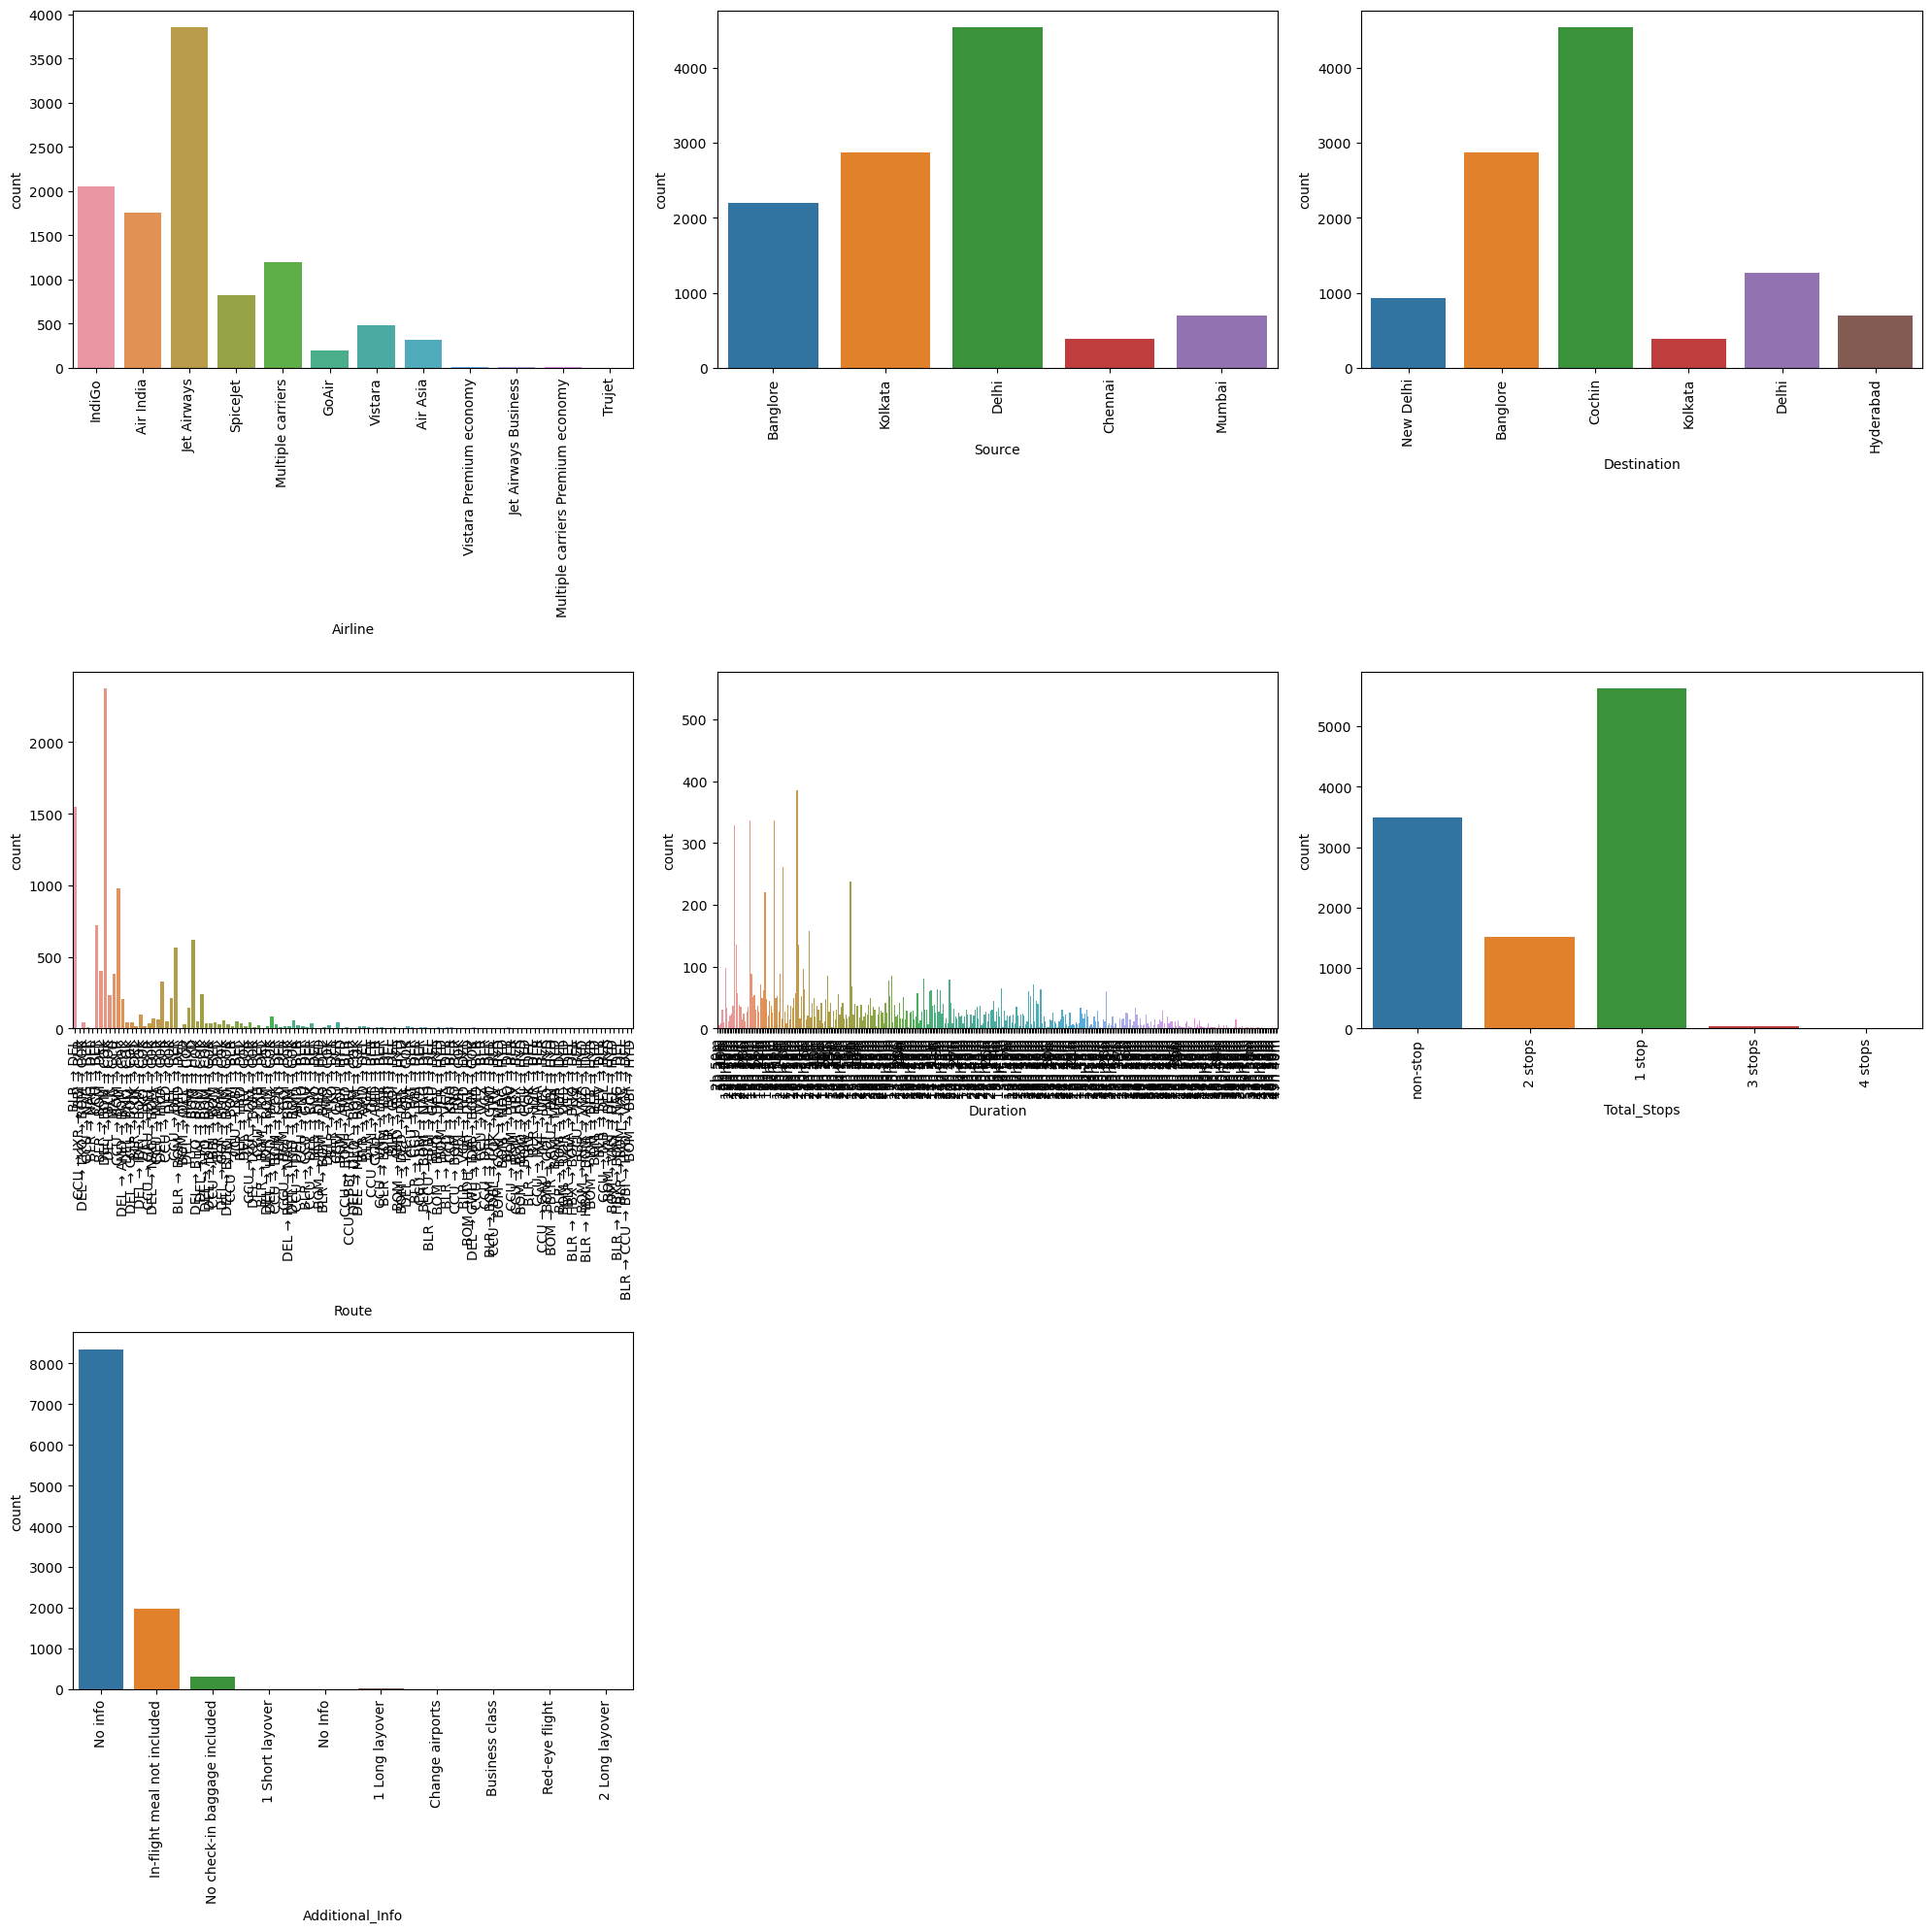

In [10]:
t = 1
plt.figure(figsize=(20,20))
for i in cat:
    plt.subplot(3,3,t)
    sns.countplot(x=train[i])
    t+=1
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Bivariate Analysis:

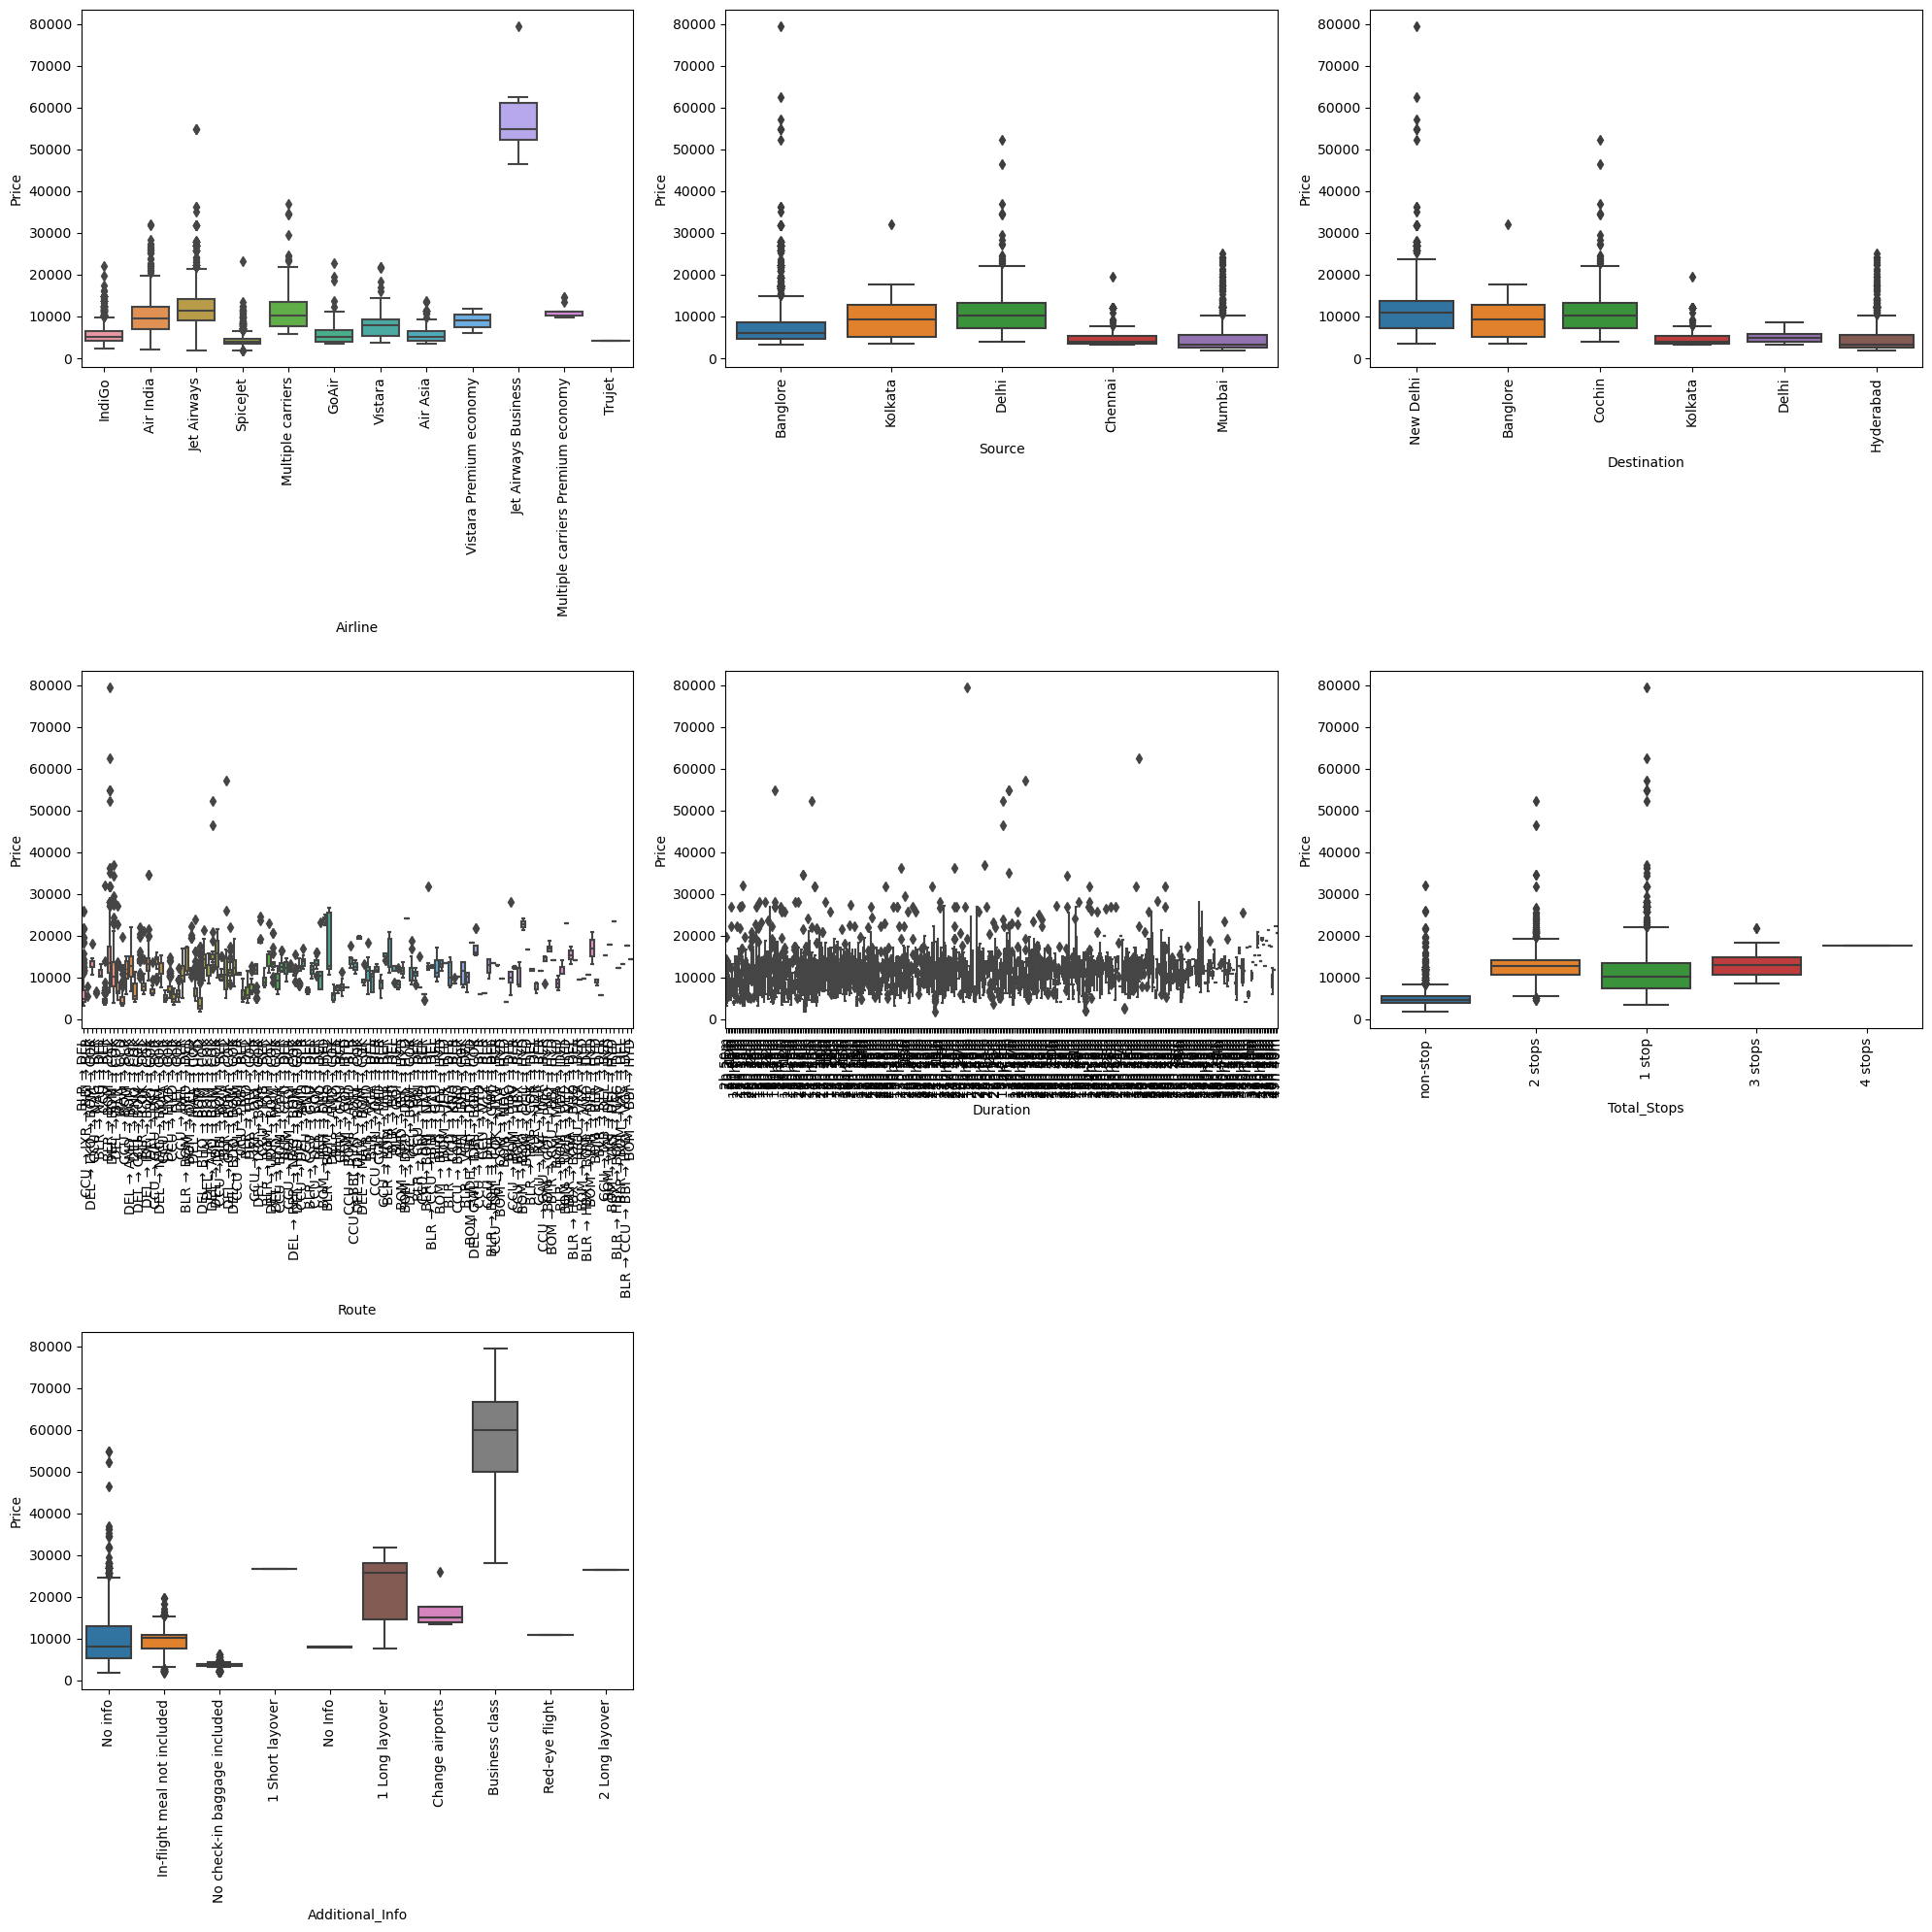

In [11]:
t = 1
plt.figure(figsize=(20,20))
for i in cat:
    plt.subplot(3,3,t)
    sns.boxplot(x=train[i],y=train['Price'])
    t+=1
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
for i in cat:
    print(train[i].value_counts())
    print('----------------------------------')
    print()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
----------------------------------

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64
----------------------------------

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64
----------------------------------

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR         

## Missing Values Treatment:

In [13]:
train.isna().sum()

Airline                   0
Date_of_Journey           0
Source                    0
Destination               0
Route                     1
Dep_Time                  0
Arrival_Time              0
Duration                  0
Total_Stops               1
Additional_Info           0
Price                     0
Date_of_Journey_new       0
Arrival_Time_new       6348
Dep_Time_new              0
dtype: int64

In [14]:
train[train.Total_Stops.isna()==True]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_new,Arrival_Time_new,Dep_Time_new
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480,2019-05-06,1900-05-07 09:25:00,1900-01-01 09:45:00


In [15]:
train[(train['Airline']=='Air India') & (train['Source']=='Delhi') & (train['Destination']=='Cochin') & (train['Date_of_Journey']=='6/05/2019')]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_new,Arrival_Time_new,Dep_Time_new
1253,Air India,6/05/2019,Delhi,Cochin,DEL → LKO → BOM → COK,12:20,19:15 07 May,30h 55m,2 stops,No info,13538,2019-05-06,1900-05-07 19:15:00,1900-01-01 12:20:00
4375,Air India,6/05/2019,Delhi,Cochin,DEL → COK,14:10,17:10,3h,non-stop,No info,6934,2019-05-06,NaT,1900-01-01 14:10:00
5488,Air India,6/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 07 May,21h 15m,2 stops,No info,11701,2019-05-06,1900-05-07 19:15:00,1900-01-01 22:00:00
8809,Air India,6/05/2019,Delhi,Cochin,DEL → MAA → COK,20:40,09:25 07 May,12h 45m,1 stop,No info,7480,2019-05-06,1900-05-07 09:25:00,1900-01-01 20:40:00
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480,2019-05-06,1900-05-07 09:25:00,1900-01-01 09:45:00


In [16]:
train[(train['Airline']=='Air India') & (train['Source']=='Delhi') & (train['Destination']=='Cochin') & (train['Date_of_Journey']=='6/05/2019')]['Route'].iloc[-2]

'DEL → MAA → COK'

In [17]:
train['Route'].fillna('DEL → MAA → COK',inplace=True)
train['Total_Stops'].fillna('1 stop',inplace=True)

In [18]:
train.isna().sum()

Airline                   0
Date_of_Journey           0
Source                    0
Destination               0
Route                     0
Dep_Time                  0
Arrival_Time              0
Duration                  0
Total_Stops               0
Additional_Info           0
Price                     0
Date_of_Journey_new       0
Arrival_Time_new       6348
Dep_Time_new              0
dtype: int64

In [19]:
train['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [20]:
train['Additional_Info'] = train['Additional_Info'].replace({'No Info':'No info'})

In [21]:
train['Additional_Info'].value_counts()

No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

## Feature Engineering:

In [22]:
train['journey_Day'] = train['Date_of_Journey_new'].dt.day
train['journey_Month'] = train['Date_of_Journey_new'].dt.month
train['journey_Day_of_Week'] = train['Date_of_Journey_new'].dt.dayofweek


In [23]:
# Extract hour and minute from 'Dep_Time' and 'Arrival_Time'
train['Dep_Hour'] = pd.to_datetime(train['Dep_Time']).dt.hour
train['Dep_Minute'] = pd.to_datetime(train['Dep_Time']).dt.minute
train['Arrival_Hour'] = pd.to_datetime(train['Arrival_Time']).dt.hour
train['Arrival_Minute'] = pd.to_datetime(train['Arrival_Time']).dt.minute

In [24]:
def convert_to_minutes(duration):
    duration = duration.split()
    if len(duration) == 2:
        hours = int(duration[0][0:-1]) * 60
        minutes = int(duration[1][0:-1])
    elif 'h' in duration[0]:
        hours = int(duration[0][0:-1]) * 60
        minutes = 0
    else:
        hours = 0
        minutes = int(duration[0][0:-1])
    return hours + minutes

train['Duration_Mins'] = train['Duration'].apply(convert_to_minutes)

In [25]:
train['Total_Stops'] = train['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4})
train['Total_Stops'] = train['Total_Stops'].astype(int)

In [26]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

train['Dep_Time_of_Day'] = train['Dep_Hour'].apply(time_of_day)
train['Arrival_Time_of_Day'] = train['Arrival_Hour'].apply(time_of_day)

In [27]:
train['journey_Day_of_Week']

0        6
1        2
2        6
3        6
4        4
        ..
10678    1
10679    5
10680    5
10681    4
10682    3
Name: journey_Day_of_Week, Length: 10683, dtype: int64

In [28]:
train['Num_Routes'] = train['Route'].apply(lambda x: len(x.split('→')) - 1)

In [29]:
train['journey_is_Weekend'] = train['journey_Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

In [30]:
pd.set_option('display.max_columns',50)

In [31]:
train.Route.str.split().iloc[1][1]

'→'

In [32]:
df_Stops = train.Route.str.split('→',expand=True)
df_Stops.rename(columns={0:'stop1',1:'stop2',2:'stop3',3:'stop4',4:'stop5',5:'stop6'},inplace=True)
df_Stops.fillna(0,inplace=True)
train = pd.concat([train, df_Stops], axis=1)
train

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_new,Arrival_Time_new,Dep_Time_new,journey_Day,journey_Month,journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Mins,Dep_Time_of_Day,Arrival_Time_of_Day,Num_Routes,journey_is_Weekend,stop1,stop2,stop3,stop4,stop5,stop6
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,2019-03-24,1900-03-22 01:10:00,1900-01-01 22:20:00,24,3,6,22,20,1,10,170,Night,Night,1,1,BLR,DEL,0,0,0,0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,2019-05-01,NaT,1900-01-01 05:50:00,1,5,2,5,50,13,15,445,Morning,Afternoon,3,0,CCU,IXR,BBI,BLR,0,0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882,2019-06-09,1900-06-10 04:25:00,1900-01-01 09:25:00,9,6,6,9,25,4,25,1140,Morning,Night,3,1,DEL,LKO,BOM,COK,0,0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218,2019-05-12,NaT,1900-01-01 18:05:00,12,5,6,18,5,23,30,325,Evening,Night,2,1,CCU,NAG,BLR,0,0,0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302,2019-03-01,NaT,1900-01-01 16:50:00,1,3,4,16,50,21,35,285,Afternoon,Night,2,0,BLR,NAG,DEL,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,0,No info,4107,2019-04-09,NaT,1900-01-01 19:55:00,9,4,1,19,55,22,25,150,Evening,Night,1,0,CCU,BLR,0,0,0,0
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,0,No info,4145,2019-04-27,NaT,1900-01-01 20:45:00,27,4,5,20,45,23,20,155,Evening,Night,1,1,CCU,BLR,0,0,0,0
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,0,No info,7229,2019-04-27,NaT,1900-01-01 08:20:00,27,4,5,8,20,11,20,180,Morning,Morning,1,1,BLR,DEL,0,0,0,0
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,0,No info,12648,2019-03-01,NaT,1900-01-01 11:30:00,1,3,4,11,30,14,10,160,Morning,Afternoon,1,0,BLR,DEL,0,0,0,0


In [33]:
# Define a function to update Arrival_Time_of_Day based on the hour
def adjust_arrival_time_of_day(hour, dep_time_of_day):
    if dep_time_of_day == 'Night' and (0 <= hour < 6):
        return 'Morning'
    return 'Night'

# Apply the function to adjust Arrival_Time_of_Day for red-eye flights
train['Arrival_Time_of_Day_n'] = train.apply(lambda x: adjust_arrival_time_of_day(x['Arrival_Hour'], x['Dep_Time_of_Day']), axis=1)

# Now mark those rows as 'Red-eye flight' in Additional_Info where departs at night and arrives in the morning
train.loc[(train['Dep_Time_of_Day'] == 'Night') & (train['Arrival_Time_of_Day_n'] == 'Morning') & (train['Additional_Info'].isin(['No Info'])), 'Additional_Info'] = 'Red-eye flight'

# Check the updated rows
train[(train['Dep_Time_of_Day'] == 'Night') & (train['Arrival_Time_of_Day_n'] == 'Morning')][['Dep_Time_of_Day', 'Arrival_Time_of_Day_n', 'Additional_Info']]['Additional_Info'].value_counts()

No info                         577
In-flight meal not included      75
No check-in baggage included     64
Red-eye flight                    1
Name: Additional_Info, dtype: int64

In [34]:
# Standardize and group Additional_Info categories
def process_additional_info(info):
    info = info.lower()  # Standardize to lowercase
    if 'no info' in info:
        return 'No info'
    elif 'layover' in info:
        return 'Has layover'
    elif info in ['business class', 'change airports', 'red-eye flight']:
        return 'Special cases'
    return info

# Apply the function to process Additional_Info
train['Additional_Info_Processed'] = train['Additional_Info'].apply(process_additional_info)

# Check the updated categories
train['Additional_Info_Processed'].value_counts()

No info                         8348
in-flight meal not included     1982
no check-in baggage included     320
Has layover                       21
Special cases                     12
Name: Additional_Info_Processed, dtype: int64

In [35]:
del train['Arrival_Time_of_Day_n']

In [36]:
train.nunique()

Airline                        12
Date_of_Journey                44
Source                          5
Destination                     6
Route                         128
Dep_Time                      222
Arrival_Time                 1343
Duration                      368
Total_Stops                     5
Additional_Info                 9
Price                        1870
Date_of_Journey_new            40
Arrival_Time_new             1169
Dep_Time_new                  222
journey_Day                    10
journey_Month                   4
journey_Day_of_Week             7
Dep_Hour                       24
Dep_Minute                     12
Arrival_Hour                   24
Arrival_Minute                 12
Duration_Mins                 368
Dep_Time_of_Day                 4
Arrival_Time_of_Day             4
Num_Routes                      5
journey_is_Weekend              2
stop1                           5
stop2                          45
stop3                          30
stop4         

In [37]:
train.shape

(10683, 33)

In [38]:
train.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey_new,Arrival_Time_new,Dep_Time_new,journey_Day,journey_Month,journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Mins,Dep_Time_of_Day,Arrival_Time_of_Day,Num_Routes,journey_is_Weekend,stop1,stop2,stop3,stop4,stop5,stop6,Additional_Info_Processed
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,2019-03-24,1900-03-22 01:10:00,1900-01-01 22:20:00,24,3,6,22,20,1,10,170,Night,Night,1,1,BLR,DEL,0,0,0,0,No info
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,2019-05-01,NaT,1900-01-01 05:50:00,1,5,2,5,50,13,15,445,Morning,Afternoon,3,0,CCU,IXR,BBI,BLR,0,0,No info


In [39]:
train_new = train.drop(columns = ['Date_of_Journey','Route','Dep_Time','Arrival_Time','Duration','Additional_Info','Date_of_Journey_new','Arrival_Time_new','Dep_Time_new'])
train_new.shape

(10683, 24)

In [40]:
train_new.head()

,Airline,Source,Destination,Total_Stops,Price,journey_Day,journey_Month,journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Mins,Dep_Time_of_Day,Arrival_Time_of_Day,Num_Routes,journey_is_Weekend,stop1,stop2,stop3,stop4,stop5,stop6,Additional_Info_Processed
0,IndiGo,Banglore,New Delhi,0,3897,24,3,6,22,20,1,10,170,Night,Night,1,1,BLR,DEL,0,0,0,0,No info
1,Air India,Kolkata,Banglore,2,7662,1,5,2,5,50,13,15,445,Morning,Afternoon,3,0,CCU,IXR,BBI,BLR,0,0,No info
2,Jet Airways,Delhi,Cochin,2,13882,9,6,6,9,25,4,25,1140,Morning,Night,3,1,DEL,LKO,BOM,COK,0,0,No info
3,IndiGo,Kolkata,Banglore,1,6218,12,5,6,18,5,23,30,325,Evening,Night,2,1,CCU,NAG,BLR,0,0,0,No info
4,IndiGo,Banglore,New Delhi,1,13302,1,3,4,16,50,21,35,285,Afternoon,Night,2,0,BLR,NAG,DEL,0,0,0,No info


### Split the data in train and test data:

In [41]:
x = train_new.drop(columns='Price')
y = train_new['Price']

In [42]:
from sklearn.model_selection import train_test_split
trainx,testx,trainy,testy = train_test_split(x,y,train_size=0.80)
trainx.shape,trainy.shape,testx.shape,testy.shape

((8546, 23), (8546,), (2137, 23), (2137,))

In [43]:
train_final = pd.concat([trainx,trainy],axis=1)
train_final.shape

(8546, 24)

In [44]:
test_final = pd.concat([testx,testy],axis=1)
test_final.shape

(2137, 24)

In [45]:
train_final['Additional_Info_Processed'].value_counts()

No info                         6700
in-flight meal not included     1551
no check-in baggage included     264
Has layover                       19
Special cases                     12
Name: Additional_Info_Processed, dtype: int64

In [46]:
train_final.shape

(8546, 24)

## Statistical Testing:

In [47]:
cats = ['Airline', 'Source', 'Destination', 'Total_Stops',
    'journey_Day_of_Week',
       'Dep_Time_of_Day', 'Arrival_Time_of_Day', 'Num_Routes',
       'journey_is_Weekend', 'stop1', 'stop2', 'stop3', 'stop4', 'stop5',
        'Additional_Info_Processed']
num = [ 'Price','Dep_Hour','journey_Day', 'journey_Month',
       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Mins']
len(cats)+len(num)
cat = ['stop6']

In [48]:
import scipy.stats as stats
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency,shapiro,levene,kruskal,mannwhitneyu

In [49]:
p=shapiro(train_final['Price'])[1]
if p>0.05:
    print('Ho: Data is Normal')
else:
    print('Ha: Data is not Normal')
p

Ha: Data is not Normal


0.0

In [50]:
for j in cats:
    grouped_data = [train_final.loc[train_final[j] == i, 'Price']  for i in train_final[j].unique()]
    p = kruskal(*grouped_data)[1]

    if p>0.05:
        print('Ho: There is no relation between Price and',j)
    else:
        print('Ha:There is significant relation between Price and',j)
    print(f'p_value for {j} is {p}')

Ha:There is significant relation between Price and Airline
p_value for Airline is 0.0
Ha:There is significant relation between Price and Source
p_value for Source is 0.0
Ha:There is significant relation between Price and Destination
p_value for Destination is 0.0
Ha:There is significant relation between Price and Total_Stops
p_value for Total_Stops is 0.0
Ha:There is significant relation between Price and journey_Day_of_Week
p_value for journey_Day_of_Week is 3.0636205827464645e-10
Ha:There is significant relation between Price and Dep_Time_of_Day
p_value for Dep_Time_of_Day is 2.7749003441133446e-20
Ha:There is significant relation between Price and Arrival_Time_of_Day
p_value for Arrival_Time_of_Day is 1.2462227167405822e-56
Ha:There is significant relation between Price and Num_Routes
p_value for Num_Routes is 0.0
Ha:There is significant relation between Price and journey_is_Weekend
p_value for journey_is_Weekend is 0.0011657627353754488
Ha:There is significant relation between Pric

In [51]:
train_final['stop6'].unique()

array([0, ' DEL'], dtype=object)

In [52]:
samp1 = train_final[train_final['stop6']==0]['Price']
samp2 = train_final[train_final['stop6']==' DEL']['Price']
mannwhitneyu(samp1,samp2)

MannwhitneyuResult(statistic=210.0, pvalue=0.09964939033977256)

In [53]:
# by this test we are to remove the stop6 but i will not remove it because it will helpful and the models accuracy will affect with these...
# i will remove total stops and num routes...

In [54]:
for i in num:
    p_value = stats.mannwhitneyu(train_final['Price'],train_final[i])[1]
    print(f'p_value for {i} is {p_value}')

p_value for Price is 1.0
p_value for Dep_Hour is 0.0
p_value for journey_Day is 0.0
p_value for journey_Month is 0.0
p_value for Dep_Minute is 0.0
p_value for Arrival_Hour is 0.0
p_value for Arrival_Minute is 0.0
p_value for Duration_Mins is 0.0


In [55]:
train_final_new = train_final
test_final_new = test_final

In [56]:
train_final_new.shape,test_final_new.shape

((8546, 24), (2137, 24))

### Feature Encoding:

In [57]:
print(train_final_new['Airline'].unique())
print()
print(test_final_new['Airline'].unique())

['Jet Airways' 'IndiGo' 'Air India' 'GoAir' 'Multiple carriers' 'Vistara'
 'SpiceJet' 'Air Asia' 'Multiple carriers Premium economy'
 'Jet Airways Business' 'Vistara Premium economy' 'Trujet']

['Jet Airways' 'Multiple carriers' 'IndiGo' 'SpiceJet' 'Air India'
 'Air Asia' 'Vistara' 'GoAir' 'Vistara Premium economy']


In [58]:
train_final_new['Airline'] = train_final_new['Airline'].map({'IndiGo':0, 'Air India':1, 'Jet Airways':2, 'SpiceJet':3,
       'Multiple carriers':4, 'GoAir':5, 'Vistara':6, 'Air Asia':7,
       'Vistara Premium economy':8, 'Jet Airways Business':9,
       'Multiple carriers Premium economy':10, 'Trujet':11})
test_final_new['Airline'] = test_final_new['Airline'].map({'IndiGo':0, 'Air India':1, 'Jet Airways':2, 'SpiceJet':3,
       'Multiple carriers':4, 'GoAir':5, 'Vistara':6, 'Air Asia':7,
       'Vistara Premium economy':8, 'Jet Airways Business':9,
       'Multiple carriers Premium economy':10, 'Trujet':11})

In [59]:
print(train_final_new['Source'].unique())
print()
print(test_final_new['Source'].unique())

['Kolkata' 'Banglore' 'Mumbai' 'Delhi' 'Chennai']

['Banglore' 'Delhi' 'Kolkata' 'Chennai' 'Mumbai']


In [60]:
train_final_new['Source'] = train_final_new['Source'].map({'Banglore':0, 'Kolkata':1, 'Delhi':2, 'Chennai':3, 'Mumbai':4})
test_final_new['Source'] = test_final_new['Source'].map({'Banglore':0, 'Kolkata':1, 'Delhi':2, 'Chennai':3, 'Mumbai':4})

In [61]:
print(train_final_new['Destination'].unique())
print()
print(test_final_new['Destination'].unique())

['Banglore' 'Delhi' 'New Delhi' 'Hyderabad' 'Cochin' 'Kolkata']

['New Delhi' 'Cochin' 'Delhi' 'Banglore' 'Kolkata' 'Hyderabad']


In [62]:
train_final_new['Destination'] = train_final_new['Destination'].map({'New Delhi':7, 'Banglore':0, 'Cochin':5, 'Kolkata':1, 'Delhi':2, 'Hyderabad':6})
test_final_new['Destination'] = test_final_new['Destination'].map({'New Delhi':7, 'Banglore':0, 'Cochin':5, 'Kolkata':1, 'Delhi':2, 'Hyderabad':6})

In [63]:
print(train_final_new['Dep_Time_of_Day'].unique())
print()
print(test_final_new['Dep_Time_of_Day'].unique())

['Night' 'Morning' 'Afternoon' 'Evening']

['Night' 'Morning' 'Afternoon' 'Evening']


In [64]:
train_final_new['Dep_Time_of_Day'] = train_final_new['Dep_Time_of_Day'].map({'Night':3, 'Morning':0, 'Evening':2, 'Afternoon':1})
test_final_new['Dep_Time_of_Day'] = test_final_new['Dep_Time_of_Day'].map({'Night':3, 'Morning':0, 'Evening':2, 'Afternoon':1})

In [65]:
print(train_final_new['Arrival_Time_of_Day'].unique())
print()
print(test_final_new['Arrival_Time_of_Day'].unique())

['Morning' 'Evening' 'Afternoon' 'Night']

['Night' 'Afternoon' 'Morning' 'Evening']


In [66]:
train_final_new['Arrival_Time_of_Day'] = train_final_new['Arrival_Time_of_Day'].map({'Night':3, 'Morning':0, 'Evening':2, 'Afternoon':1})
test_final_new['Arrival_Time_of_Day'] = test_final_new['Arrival_Time_of_Day'].map({'Night':3, 'Morning':0, 'Evening':2, 'Afternoon':1})

In [67]:
print(train_final_new['stop1'].unique())
print()
print(test_final_new['stop1'].unique())

['CCU ' 'BLR ' 'BOM ' 'DEL ' 'MAA ']

['BLR ' 'DEL ' 'CCU ' 'MAA ' 'BOM ']


In [68]:
train_final_new['stop1'] = train_final_new['stop1'].map({'BLR ':0, 'CCU ':1, 'DEL ':2, 'MAA ':3, 'BOM ':4})
test_final_new['stop1'] = test_final_new['stop1'].map({'BLR ':0, 'CCU ':1, 'DEL ':2, 'MAA ':3, 'BOM ':4})

In [69]:
train_final_new['stop2'].unique()

array([' BOM ', ' DEL', ' DEL ', ' BLR', ' HYD', ' HYD ', ' CCU', ' AMD ',
       ' JDH ', ' IXR ', ' JAI ', ' IDR ', ' VGA ', ' MAA ', ' BLR ',
       ' COK', ' ATQ ', ' GAU ', ' GOI ', ' BHO ', ' BBI ', ' CCU ',
       ' NAG ', ' IXB ', ' COK ', ' DED ', ' LKO ', ' RPR ', ' PNQ ',
       ' UDR ', ' GWL ', ' TRV ', ' BDQ ', ' IXC ', ' IXU ', ' KNU ',
       ' HBX ', ' IXA ', ' PAT ', ' STV ', ' VNS ', ' VTZ ', ' NDC ',
       ' IXZ '], dtype=object)

In [70]:
airport_encoding = {
    ' DEL': 2,   # Delhi
    ' IXR ': 11, # Birsa Munda Airport (Ranchi)
    ' LKO ': 15, # Chaudhary Charan Singh International Airport (Lucknow)
    ' NAG ': 16, # Dr. Babasaheb Ambedkar International Airport (Nagpur)
    ' BLR': 5,   # Bangalore
    ' BOM ': 4,  # Mumbai
    ' BLR ': 5,  # Bangalore
    ' CCU': 1,   # Kolkata
    ' AMD ': 10, # Sardar Vallabhbhai Patel International Airport (Ahmedabad)
    ' PNQ ': 6,  # Pune International Airport
    ' CCU ': 1,  # Kolkata
    ' COK ': 7,  # Cochin International Airport
    ' IDR ': 36, # Devi Ahilya Bai Holkar Airport (Indore)
    ' GAU ': 9,  # Lokpriya Gopinath Bordoloi International Airport (Guwahati)
    ' MAA ': 3,  # Chennai
    ' HYD ': 8,  # Rajiv Gandhi International Airport (Hyderabad)
    ' COK': 7,   # Cochin International Airport
    ' DEL ': 2,  # Delhi
    ' HYD': 8,   # Hyderabad
    ' BHO ': 12, # Raja Bhoj International Airport (Bhopal)
    ' JAI ': 13, # Jaipur International Airport
    ' ATQ ': 14, # Sri Guru Ram Dass Jee International Airport (Amritsar)
    ' JDH ': 37, # Jodhpur Airport
    ' BBI ': 33, # Biju Patnaik International Airport (Bhubaneswar)
    ' GOI ': 18, # Goa International Airport
    ' BDQ ': 34, # Vadodara International Airport
    ' TRV ': 17, # Trivandrum International Airport
    ' IXU ': 40, # Aurangabad Airport
    ' IXB ': 20, # Bagdogra Airport
    ' UDR ': 21, # Maharana Pratap Airport (Udaipur)
    ' RPR ': 22, # Swami Vivekananda Airport (Raipur)
    ' DED ': 35, # Jolly Grant Airport (Dehradun)
    ' VGA ': 23, # Vijayawada Airport
    ' VNS ': 29, # Lal Bahadur Shastri Airport (Varanasi)
    ' IXC ': 19, # Chandigarh International Airport
    ' PAT ': 24, # Jay Prakash Narayan Airport (Patna)
    ' JLR ': 25, # Jabalpur Airport
    ' KNU ': 26, # Kanpur Airport
    ' GWL ': 27, # Gwalior Airport
    ' VTZ ': 28, # Visakhapatnam International Airport
    ' NDC ': 36, # Nanded Airport
    ' IXZ ': 29, # Veer Savarkar International Airport (Port Blair)
    ' HBX ': 30, # Hubli Airport
    ' IXA ': 31, # Maharaja Bir Bikram Airport (Agartala)
    ' STV ': 32,  # Surat International Airport
    0:0
}


In [71]:
for i in train_final_new['stop3'].unique():
    if i in airport_encoding.keys():
        pass
    else:
        print(i)

 IMF 
 ISK 


In [72]:
# Applying the same mapping for all stop columns
train_final_new['stop2'] = train_final_new['stop2'].map(airport_encoding)
train_final_new['stop4'] = train_final_new['stop4'].map(airport_encoding)
train_final_new['stop5'] = train_final_new['stop5'].map(airport_encoding)
train_final_new['stop6'] = train_final_new['stop6'].map(airport_encoding)

test_final_new['stop2'] = test_final_new['stop2'].map(airport_encoding)
test_final_new['stop4'] = test_final_new['stop4'].map(airport_encoding)
test_final_new['stop5'] = test_final_new['stop5'].map(airport_encoding)
test_final_new['stop6'] = test_final_new['stop6'].map(airport_encoding)

In [73]:
airport_encoding = {
    ' DEL': 2,   # Delhi
    ' IXR ': 11, # Birsa Munda Airport (Ranchi)
    ' LKO ': 15, # Chaudhary Charan Singh International Airport (Lucknow)
    ' NAG ': 16, # Dr. Babasaheb Ambedkar International Airport (Nagpur)
    ' BLR': 5,   # Bangalore
    ' BOM ': 4,  # Mumbai
    ' BLR ': 5,  # Bangalore
    ' CCU': 1,   # Kolkata
    ' AMD ': 10, # Sardar Vallabhbhai Patel International Airport (Ahmedabad)
    ' PNQ ': 6,  # Pune International Airport
    ' CCU ': 1,  # Kolkata
    ' COK ': 7,  # Cochin International Airport
    ' IDR ': 36, # Devi Ahilya Bai Holkar Airport (Indore)
    ' GAU ': 9,  # Lokpriya Gopinath Bordoloi International Airport (Guwahati)
    ' MAA ': 3,  # Chennai
    ' HYD ': 8,  # Rajiv Gandhi International Airport (Hyderabad)
    ' COK': 7,   # Cochin International Airport
    ' DEL ': 2,  # Delhi
    ' HYD': 8,   # Hyderabad
    ' BHO ': 12, # Raja Bhoj International Airport (Bhopal)
    ' JAI ': 13, # Jaipur International Airport
    ' ATQ ': 14, # Sri Guru Ram Dass Jee International Airport (Amritsar)
    ' JDH ': 37, # Jodhpur Airport
    ' BBI ': 33, # Biju Patnaik International Airport (Bhubaneswar)
    ' GOI ': 18, # Goa International Airport
    ' BDQ ': 34, # Vadodara International Airport
    ' TRV ': 17, # Trivandrum International Airport
    ' IXU ': 40, # Aurangabad Airport
    ' IXB ': 20, # Bagdogra Airport
    ' UDR ': 21, # Maharana Pratap Airport (Udaipur)
    ' RPR ': 22, # Swami Vivekananda Airport (Raipur)
    ' DED ': 35, # Jolly Grant Airport (Dehradun)
    ' VGA ': 23, # Vijayawada Airport
    ' VNS ': 29, # Lal Bahadur Shastri Airport (Varanasi)
    ' IXC ': 19, # Chandigarh International Airport
    ' PAT ': 24, # Jay Prakash Narayan Airport (Patna)
    ' JLR ': 25, # Jabalpur Airport
    ' KNU ': 26, # Kanpur Airport
    ' GWL ': 27, # Gwalior Airport
    ' VTZ ': 28, # Visakhapatnam International Airport
    ' NDC ': 36, # Nanded Airport
    ' IXZ ': 29, # Veer Savarkar International Airport (Port Blair)
    ' HBX ': 30, # Hubli Airport
    ' IXA ': 31, # Maharaja Bir Bikram Airport (Agartala)
    ' STV ': 32,  # Surat International Airport
    ' ISK ': 39, # Nashik Airport
    ' IMF ': 38,  # Imphal International Airport
    0:0
}


In [74]:
train_final_new['stop3'] = train_final_new['stop3'].map(airport_encoding)
test_final_new['stop3'] = test_final_new['stop3'].map(airport_encoding)

In [75]:
test_final_new['Additional_Info_Processed'].unique()

array(['No info', 'in-flight meal not included',
       'no check-in baggage included', 'Has layover'], dtype=object)

In [76]:
train_final_new['Additional_Info_Processed'] = train_final_new['Additional_Info_Processed'].map({'No info':0, 'in-flight meal not included':1, 'Has layover':2,
       'no check-in baggage included':3, 'Special cases':4})

test_final_new['Additional_Info_Processed'] = test_final_new['Additional_Info_Processed'].map({'No info':0, 'in-flight meal not included':1, 'Has layover':2,
       'no check-in baggage included':3, 'Special cases':4})


In [77]:
train_final_new.head(3)

,Airline,Source,Destination,Total_Stops,journey_Day,journey_Month,journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Mins,Dep_Time_of_Day,Arrival_Time_of_Day,Num_Routes,journey_is_Weekend,stop1,stop2,stop3,stop4,stop5,stop6,Additional_Info_Processed,Price
174,2,1,0,1,6,5,0,21,10,9,20,730,3,0,2,0,1,4,5,0,0,0,1,9663
3828,0,0,2,0,9,5,3,6,5,8,50,165,0,0,1,0,0,2,0,0,0,0,0,4077
6590,2,0,7,1,21,3,3,14,5,19,10,305,1,2,2,0,0,4,2,0,0,0,1,7832


In [78]:
train_final_new.head(3)

,Airline,Source,Destination,Total_Stops,journey_Day,journey_Month,journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_Mins,Dep_Time_of_Day,Arrival_Time_of_Day,Num_Routes,journey_is_Weekend,stop1,stop2,stop3,stop4,stop5,stop6,Additional_Info_Processed,Price
174,2,1,0,1,6,5,0,21,10,9,20,730,3,0,2,0,1,4,5,0,0,0,1,9663
3828,0,0,2,0,9,5,3,6,5,8,50,165,0,0,1,0,0,2,0,0,0,0,0,4077
6590,2,0,7,1,21,3,3,14,5,19,10,305,1,2,2,0,0,4,2,0,0,0,1,7832


In [79]:
x_train = train_final_new.drop(columns='Price')
y_train = train_final_new['Price']

In [80]:
x_test = test_final_new.drop(columns='Price')
y_test = test_final_new['Price']

## Modelling and Evaluation of the models:

In [81]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor,StackingRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [82]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=18,n_jobs=-1,warm_start=True)
rf.fit(x_train,y_train)



RandomForestRegressor(max_depth=18, n_estimators=1000, n_jobs=-1,
                      warm_start=True)

In [83]:
pred_rf = rf.predict(x_train)
r2_score(y_train,pred_rf)

0.9815285452466718

In [84]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=18,n_jobs=-1,warm_start=True)
rf.fit(x_train,y_train)
pred_rf = rf.predict(x_test)
r2_score(y_test,pred_rf)


0.932231768994458

In [85]:
gbm = GradientBoostingRegressor(n_estimators=700,max_depth=5,warm_start=True)
gbm.fit(x_train,y_train)
pred_gbm = gbm.predict(x_test)
r2_score(y_test,pred_gbm)

0.9315543108448421

In [86]:
gbm = XGBRegressor()
gbm.fit(x_train,y_train)
pred_gbm = gbm.predict(x_test)
r2_score(y_test,pred_gbm)

0.9289868581659104

In [87]:
dt = DecisionTreeRegressor(max_depth=14)
dt.fit(x_train,y_train)
pred_gbm = dt.predict(x_test)
r2_score(y_test,pred_gbm)

0.8887486266748169

In [88]:
GBM = GradientBoostingRegressor(n_estimators=700,max_depth=5,warm_start=True)
XGB = XGBRegressor()
DT = DecisionTreeRegressor(max_depth=14)
RF = RandomForestRegressor(n_estimators=1000,max_depth=18,n_jobs=-1,warm_start=True)


base_estimators = [('GBM',GBM),('RF',RF),('DT',DT)]
stack = StackingRegressor(estimators = base_estimators,final_estimator=XGB,cv=5,n_jobs=-1)

pred_stack = stack.fit(x_train,y_train).predict(x_test)
r2_score(testy,pred_stack)

0.9257647016396285

### Best Model for prediction ticket price is Random Forest with Accuracy level 93.22%.

# END.....